In [16]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython.display import clear_output
from tqdm import trange
from pandas import DataFrame

import a3c

import importlib
importlib.reload(a3c)

<module 'a3c' from '/Users/chris/programming/projects/rl_portfolio/a3c.py'>

In [17]:
# Define constants
GYM_ENVIRON_NAME = "CartPole-v0"
MAX_EPISODE_STEPS = None
N_ENVIRONS = 10
REWARD_SCALE = 1.   # Can be used prevent exploding gradients via rescaling of rewards

In [18]:
env = a3c.make_env(GYM_ENVIRON_NAME, max_steps=MAX_EPISODE_STEPS)

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)

# Initialize the agent (containing the Neural-Network)
agent = a3c.Agent(env, reward_scale=REWARD_SCALE)

Observation shape: (4,)
Num actions: 2


In [19]:
ewma = lambda x, span=100: DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

env_batch = a3c.EnvBatch(GYM_ENVIRON_NAME, n_envs=N_ENVIRONS, max_steps=MAX_EPISODE_STEPS)
batch_states = env_batch.reset()

rewards_history = []
entropy_history = []

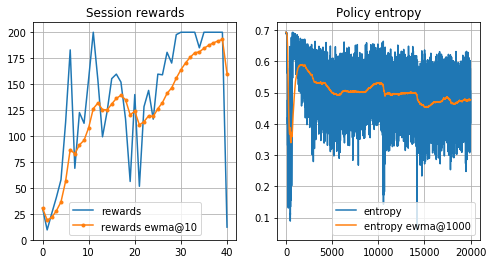

100%|██████████| 20001/20001 [05:38<00:00, 59.09it/s]


In [20]:
for i in trange(20001):
    batch_actions = agent.sample_actions(agent.step(batch_states))
    batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

    # Train the neural network from the states, rewards and transitions
    loss, ent_t = agent.train_step( batch_states, batch_next_states, \
                                  batch_actions, batch_rewards, batch_done, gamma=0.99 )    
    batch_states = batch_next_states
    entropy_history.append(np.mean(ent_t))

    if i % 500 == 0:
        if i % 500 == 0:
            avg_score = np.mean( agent.play_games( env, n_games=3 ) )
            rewards_history.append(avg_score)

        clear_output(True)
        plt.figure(figsize=[8, 4])
        plt.subplot(1, 2, 1)
        plt.plot(rewards_history, label='rewards')
        plt.plot(ewma(np.array(rewards_history), span=10), marker='.', label='rewards ewma@10')
        plt.title("Session rewards")
        plt.grid()
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(entropy_history, label='entropy')
        plt.plot(ewma(np.array(entropy_history), span=1000), label='entropy ewma@1000')
        plt.title("Policy entropy")
        plt.grid()
        plt.legend()
        plt.show()